# Multiclass Text Classification using LSTM architecture
(Runs best on a TPU)

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [44]:
df = pd.read_csv('drive/MyDrive/Multiclass Text Classification/intent.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6679 entries, 0 to 6678
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   motivos  6679 non-null   object 
 1   crec     6679 non-null   int64  
 2   cred     6679 non-null   int64  
 3   equ      6679 non-null   int64  
 4   inic     6679 non-null   int64  
 5   inv      6679 non-null   int64  
 6   mkt      6679 non-null   int64  
 7   no       6679 non-null   int64  
 8   renta    6679 non-null   int64  
 9   sueldo   6679 non-null   int64  
 10  temp     6673 non-null   float64
dtypes: float64(1), int64(9), object(1)
memory usage: 574.1+ KB


In [45]:
df['temp'].fillna(df['temp'].median(), inplace=True)
df.isna().sum()

motivos    0
crec       0
cred       0
equ        0
inic       0
inv        0
mkt        0
no         0
renta      0
sueldo     0
temp       0
dtype: int64

In [46]:
df = df.astype({"temp":'int'}) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6679 entries, 0 to 6678
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   motivos  6679 non-null   object
 1   crec     6679 non-null   int64 
 2   cred     6679 non-null   int64 
 3   equ      6679 non-null   int64 
 4   inic     6679 non-null   int64 
 5   inv      6679 non-null   int64 
 6   mkt      6679 non-null   int64 
 7   no       6679 non-null   int64 
 8   renta    6679 non-null   int64 
 9   sueldo   6679 non-null   int64 
 10  temp     6679 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 574.1+ KB


In [47]:
df['category'] = df.drop(['motivos'], axis=1).idxmax(axis=1)
df['category_id'] = df['category'].factorize()[0]
df.head()

,motivos,crec,cred,equ,inic,inv,mkt,no,renta,sueldo,temp,category,category_id
0,Crear un departamento de ventas e inversión a ...,0,0,0,0,0,1,0,0,0,0,mkt,0
1,establecerme en un local y agregar materia pri...,0,0,0,0,1,0,0,1,0,0,inv,1
2,Compra de equipo e incrementar inventario,0,0,1,0,1,0,0,0,0,0,equ,2
3,Invertir en crecimiento de flotilla de unidade...,0,0,1,0,0,0,0,0,0,0,equ,2
4,Para comprar mercancía y comprar lonas nuevas,0,0,0,0,1,0,0,0,0,0,inv,1


In [48]:
df.category.value_counts()

inv       2048
equ       1910
crec       601
renta      453
no         440
cred       422
inic       372
mkt        212
temp       142
sueldo      79
Name: category, dtype: int64

### Label Consolidation
En este caso no hace falta

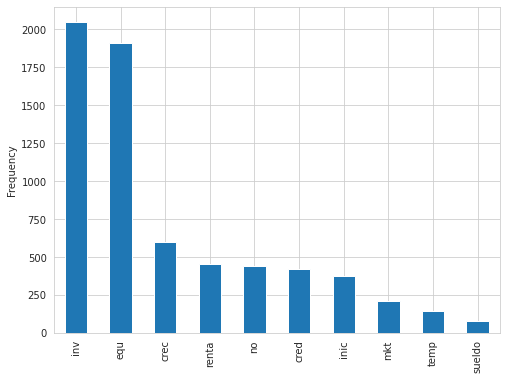

In [51]:
plt.figure(figsize=(8, 6))
df['category'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

## Text Pre-processing
Our text preprocessing will include the following steps:

- Convert all text to lower case.
- Replace REPLACE_BY_SPACE_RE symbols by space in text.
- Remove symbols that are in BAD_SYMBOLS_RE from text.
- Remove “x” in text.
- Remove stop words.
- Remove digits in text.

In [28]:
def print_plot(index):
    example = df[df.index == index][['motivos', 'category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('category:', example[1])

In [29]:
print_plot(10)
print_plot(100)

INVENTARIO PARA VENDER MUEBLES DE OFICINA
category: inv
Enganche de dos autos para aumentar flotilla de carros uber
category: equ


A qué le llaman enganche en méjico?

In [30]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
import re

df = df.reset_index(drop=True)

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('spanish'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['motivos'] = df['motivos'].apply(clean_text)
df['motivos'] = df['motivos'].str.replace('\d+', '')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
print_plot(10)
print_plot(100)
print_plot(9)
print_plot(7)

inventario vender muebles oficina
category: inv
enganche dos autos aumentar flotilla carros uber
category: equ
crdito quiero adaptar local propiedad venta formal comida
category: inic
ampliaciin negocio rentar mashabitaciones
category: crec


Después del pre procesamiento, hay palabras con typos que no se pierden, que los spell checkers online al menos no pueden corregir. En caso de tener que hacerlo a mano, hay que tener una idea de cuánto puede llegar a impactar. Da la impresión de que el porcentaje de casos es chico, con lo cual posiblemente no afecte mucho.

## LSTM Modeling
- Vectorize consumer complaints text, by turning each text into either a sequence of integers or into a vector.
- Limit the data set to the top 5,0000 words.
- Set the max number of words in each complaint at 250.

Estas cosas las tendría que **tunear**.

In [32]:
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['motivos'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 7993 unique tokens.


Truncate and pad the input sequences so that they are all in the same length for modeling:

In [33]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df['motivos'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', X.shape)

Shape of data tensor: (6679, 250)


### Converting categorical labels to numbers - ya está
Para la target tendría que tirar category category_id?

In [34]:
# Y = pd.get_dummies(df['Product']).values

Y = df.drop(['motivos', 'category', 'category_id'], axis=1)
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (6679, 10)


In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6011, 250) (6011, 10)
(668, 250) (668, 10)


In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6011, 250) (6011, 10)
(668, 250) (668, 10)


- The first layer is the embedded layer that uses 100 length vectors to represent each word.
- SpatialDropout1D performs variational dropout in NLP models.
- The next layer is the LSTM layer with 100 memory units.
- The output layer must create 13 output values, one for each class.
- Activation function is softmax for multi-class classification.
- Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

In [37]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

model_check = ModelCheckpoint('drive/MyDrive/Multiclass Text Classification/best_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
csv_logger = CSVLogger('drive/MyDrive/Multiclass Text Classification/train_log.csv', separator=',')

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 50
batch_size = 64
# batch_size = 32

# history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[model_check, early, reduce_lr, csv_logger])

Epoch 1/50
85/85 [==============================] - 99s 826ms/step - loss: 2.3742 - accuracy: 0.2894 - val_loss: 2.1334 - val_accuracy: 0.3870
Epoch 2/50
85/85 [==============================] - 69s 809ms/step - loss: 2.1127 - accuracy: 0.4125 - val_loss: 1.7399 - val_accuracy: 0.5365
Epoch 3/50
85/85 [==============================] - 68s 803ms/step - loss: 1.6565 - accuracy: 0.5679 - val_loss: 1.5173 - val_accuracy: 0.5963
Epoch 4/50
85/85 [==============================] - 69s 815ms/step - loss: 1.4399 - accuracy: 0.6455 - val_loss: 1.4317 - val_accuracy: 0.6279
Epoch 5/50
85/85 [==============================] - 68s 801ms/step - loss: 1.2606 - accuracy: 0.7124 - val_loss: 1.3824 - val_accuracy: 0.6512
Epoch 6/50
85/85 [==============================] - 69s 811ms/step - loss: 1.1139 - accuracy: 0.7583 - val_loss: 1.3818 - val_accuracy: 0.6578
Epoch 7/50
85/85 [==============================] - 69s 810ms/step - loss: 0.9899 - accuracy: 0.8065 - val_loss: 1.3673 - val_accuracy: 0.6661

In [38]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

print(model.metrics_names)

21/21 [==============================] - 1s 67ms/step - loss: 1.5310 - accuracy: 0.6482
Test set
  Loss: 1.531
  Accuracy: 0.648
['loss', 'accuracy']


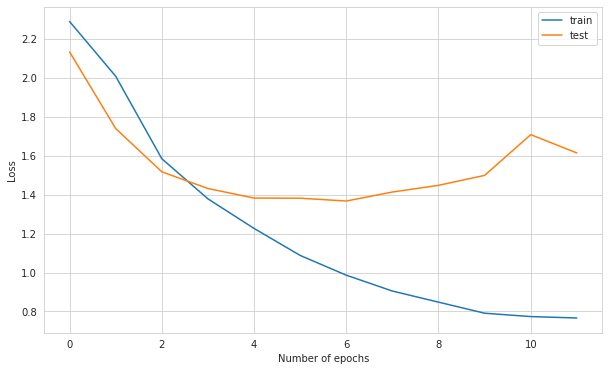

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

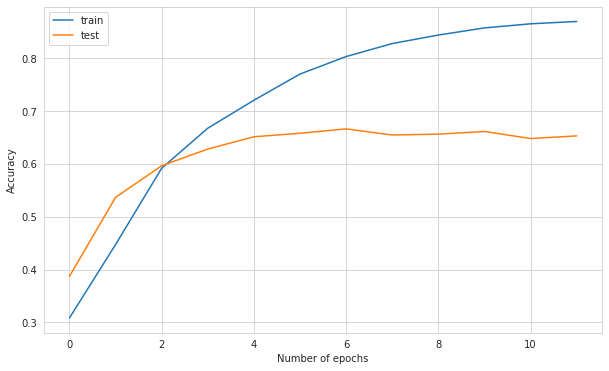

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

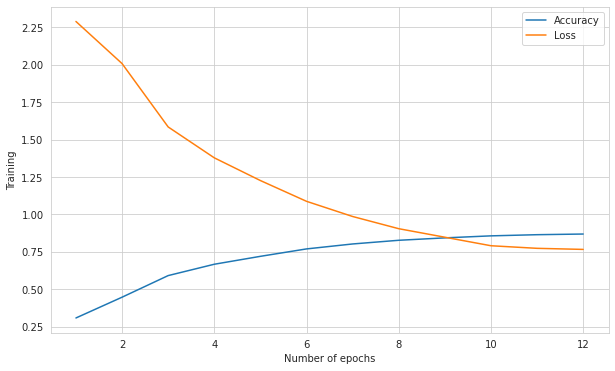

In [56]:
q = len(list(history.history['loss']))
plt.figure(figsize=(10, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Accuracy')
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Training')
plt.legend();

In [42]:
# Saving the model
model.save('drive/MyDrive/Multiclass Text Classification/LSTM_2.h5')

# Qué mejorar
- Armar un primer documento
- Comparar con lo que lograron ellos:
  - Las otras métricas están implementadas en lo de Susan Li.

  - Usar precision. Eso se cambia en model.compile
    - Usually when the class distribution is unbalanced (like we have here), accuracy is considered a poor choice as it gives high scores to models which just predict the most frequent class so **F1 score is a better choice** in our case.
    
    - For multiclass classification you also need to select the **type of averaging** for these metrics as they are **calculated per class**. The discussion of what’s best and what you should use depends on your situation and is beyond the scope of this article but in general I find macro averaging the most useful (which is what I’m using here). It computes F1 scores for each class and returns the average of those scores. Remember though, the real test is how they perform on unseen articles.
  - Mirar el loss score
  - Dónde pongo el weakness score
- Solucionar el overfitting
  - hyperparameters? batch size?